# LightGBM

LightGBM (Light Gradient Boosting Machine) est aussi une implémentation avancée de l'algorithme de Gradient Boosting. Tout comme XGBoost, il prédit les erreurs à chaque itération. Cependant, il présente certaines améliorations.

1- **Croissance Feuille-à-Feuille:**
LightGBM n'utilise pas la stratégie de croissance des arbres de décision de niveau utilisée par la plupart des méthodes ensemblistes, et adopte un algorithme de type "feuille-à-feuille" (leaf-wise) avec des limites de profondeur\cite{lx}.

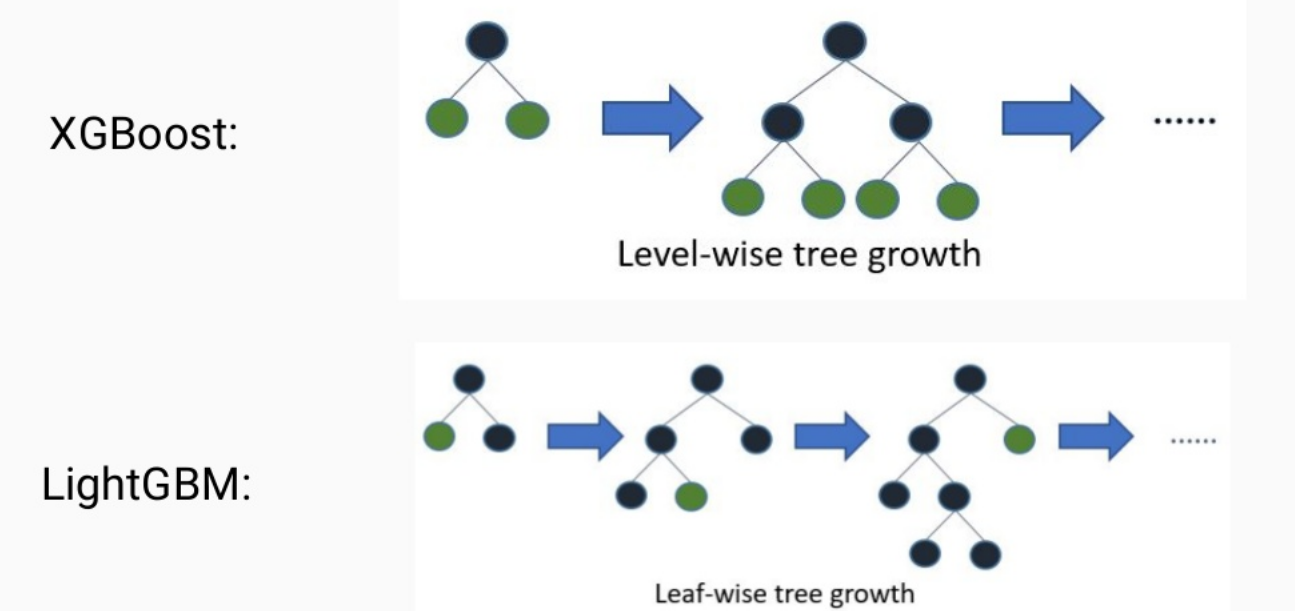

In [1]:
from IPython.display import Image
image_path = "/home/jovyan/github intro/leaf-wise lgbm.png"
width = 500
height = 500
Image(filename=image_path, width=width, height=height)

A chaque étape, parmi toutes les feuilles de l'arbre, il recherche le noeud enfant ayant le gain de division le plus élevé, et effectue ensuite la division uniquement sur ce noeud, et répète le processus.

2- **Partitionnement des noeuds de l'arbre basé sur l'histogramme}:**
Lightgbm utilise une méthode spécifique pour rechercher le meilleur point de division d'un noeud. Plutôt que d'explorer toutes les valeurs possibles d'une variable pour déterminer le point de division optimal, LightGBM utilise une approche basée sur des histogrammes. Premièrement, il trie les données par ordre croissant. Le nombre d'intervals est un hyperparamètre à optimiser. 


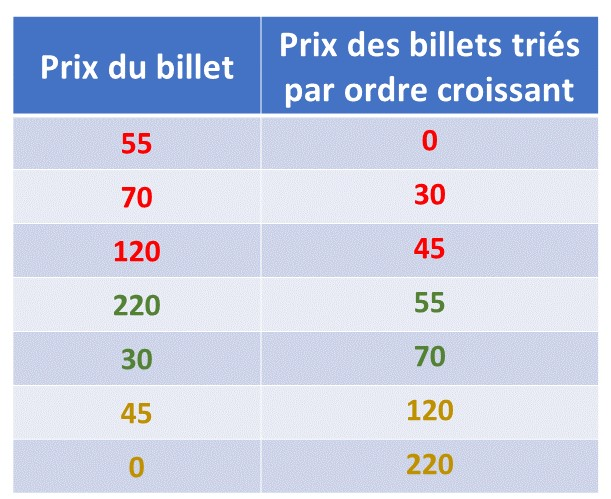

In [5]:
from IPython.display import Image
image_path = "/home/jovyan/github intro/lgbm hist.jpg"
width = 300
height = 300
Image(filename=image_path, width=width, height=height)

Supposons que nous souhaitons diviser le prix en trois intervalles (bins) :
- Intervalle 1 : De 0 à 45 ans
- Intervalle 2 : De 55 à 70 ans
- Intervalle 3 : De 120 à 220 ans

Il examine chaque bord entre les intervalles comme un point de division potentiel. Dans cet exemple, les points de division potentiels sont : 45, 55, 70 et 120. Enfin, il compare les gains potentiels pour chaque point de division potentiel et sélectionne celui qui offre le meilleur gain total.

Cette méthode permet de réduire considérablement le temps de calcul nécessaire pour trouver le meilleur point de division, tout en maintenant la qualité des décisions de division.

3- **Échantillonnage d'un côté basé sur le gradient:**
Lightgbm utilise une technique avancée d'échantillonnage nommée GOSS, (ou Gradient-based One-Side Sampling), qui se base sur l'information fournie par les gradients\cite{lgbm}. %L'idée principale consiste, avant de former l'arbre d'ensemble suivant, à considérer les observations qui ont un gradient relativement important et à exclure certaines des observations d'entraînement qui ont un gradient faible:

- Tout d'abord, il trie les observations en fonction de la valeur absolue de leurs gradients %: celles dont les prédictions actuelles sont très éloignées des valeurs cibles, c'est-à-dire ceux qui contribuent le plus à l'erreur du modèle, seront placés en haut de la liste.
    
- Les premières observations, correspondant aux plus grands gradients, sont sélectionnées.

- Les observations qui n'ont pas été sélectionnées comme principales (en raison de gradients plus faibles) sont soumises à un échantillonnage aléatoire pour former un sous-ensemble de taille B. Cette étape vise à conserver un échantillon représentatif de données avec des gradients plus faibles.

- Lorsque l'algorithme évalue le gain d'information pour diviser les nœuds de l'arbre de décision, il multiplie les erreurs des observations choisies avec de faibles gradients par une constante égale à \begin{equation}\frac{1 - A}{B} \end{equation}. Ce qui permet d'accorder une importance pour les cas plus difficiles à prédire lors de la construction de l'arbre de décision. Ainsi, les exemples ayant de faibles gradients auront moins d'influence sur le calcul du gain d'information par rapport à ceux avec des gradients élevés.

Cette approche permet d'accélérer l'apprentissage qui est particulièrement efficace pour notre problème où on a des données de grande dimension, tout en accordant à chaque fois une importance aux observations mal classées.

4- **Division optimale pour les variables catégorielles:**

Lorsqu'il s'agit de diviser les nœuds d'un arbre en fonction de variables catégorielles, la méthode courante consiste à prendre en compte la présence ou l'absence de chaque catégorie. Cependant, cette approche a tendance à créer un déséquilibre dans la répartition des données entre les nœuds enfants, ce qui nécessite une profondeur importante de l'arbre pour obtenir une précision satisfaisante. Cela rend la construction de l'arbre inefficace. LightGBM adopte une stratégie différente pour diviser les données, améliorant ainsi l'efficacité de construction de l'arbre.

Comme détaillé avant, lorsqu'il s'agit de diviser les noeuds en fonction d'une variable catégorielle, le processus se fait selon la présence ou l'abscence de la catégorie. Cependant, cette approche a tendance à créer un déséquilibre dans la répartition des données entre les noeuds enfants (une catégorie contre toutes les autres dans la variable) et réduit la précision. LightGBM utilise une autre stratégie :

- Pour chaque catégorie de la caractéristique, le modèle calcule la valeur moyenne suivante :

\begin{equation}
\frac{\text{Somme des valeurs de la variable cible}}{\text{le nombre d'observations qui appartiennent à cette catégorie}}
\end{equation}
   
Dans le contexte de notre classification binaire, cette valeur donne une estimation de la proportion de la fraude au sein de cette catégorie spécifique. %Cette estimation est précieuse pour évaluer l'impact de la caractéristique catégorielle sur la variable cible binaire.

- Puis il trie toutes les catégories par leur valeur moyenne par ordre croissant pour trouver la meilleure valeur de division. La valeur de division regroupe toutes les catégories en deux parties (catégorie dont la valeur moyenne est inférieure ou supérieure à la valeur de division), et c'est la condition de division du noeud.

# LightGBM with Scikit-Learn

In [4]:
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = sns.load_dataset('titanic')
df = pd.DataFrame(df)
df = df[["pclass", "sex", "age", "fare", "class" ,"survived"]]
df

,pclass,sex,age,fare,class,survived
0,3,male,22.0,7.2500,Third,0
1,1,female,38.0,71.2833,First,1
2,3,female,26.0,7.9250,Third,1
3,1,female,35.0,53.1000,First,1
4,3,male,35.0,8.0500,Third,0
...,...,...,...,...,...,...
886,2,male,27.0,13.0000,Second,0
887,1,female,19.0,30.0000,First,1
888,3,female,NaN,23.4500,Third,0
889,1,male,26.0,30.0000,First,1


In [6]:
df['age'] = df['age'].fillna(df['age'].median())

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OrdinalEncoder

#sex
lb = LabelBinarizer()
df["sex"] = lb.fit_transform(df["sex"])

#class
ordinal_encoder = OrdinalEncoder()
df[["class"]] = ordinal_encoder.fit_transform(df[["class"]])

In [8]:
X = df.drop('survived', axis=1)
y = df[["survived"]]

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2]:
pip install lightgbm

  Using cached lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

model = lgb.LGBMClassifier()

param_dist = {
    'n_estimators': np.arange(50, 250, 10),
    'max_depth': np.arange(2, 15),
    'learning_rate': np.logspace(-3, 0, num=100),
    'num_leaves': np.arange(2, 100),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'subsample': np.linspace(0.7, 1.0, 10),
    'reg_alpha': np.logspace(-3, 3, num=100),
    'reg_lambda': np.logspace(-3, 3, num=100),
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, scoring='f1', n_jobs=-1, cv=5, verbose=1, random_state=42)

random_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres : ", random_search.best_params_)

**Entraînement du modèle avec les meilleurs paramètres**

In [ ]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

 **Prédiction sur les données de test**

In [ ]:
y_pred = best_model.predict(X_test)

**Evaluation des résultats:**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print("Accuracy :", accuracy)
print("Precision :", precision)
print("Recall :", recall)
print("F1 Score :", f1)

In [ ]:
confusion_matrix = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix :\n", confusion_matrix)